In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [ ]:
!jupyter nbconvert --to html lab2.ipynb

[NbConvertApp] Converting notebook lab2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 2838095 bytes to lab2.html


Кумирова Екатерина M34021

**Лабораторная работа №2**

Контур Чебурашки

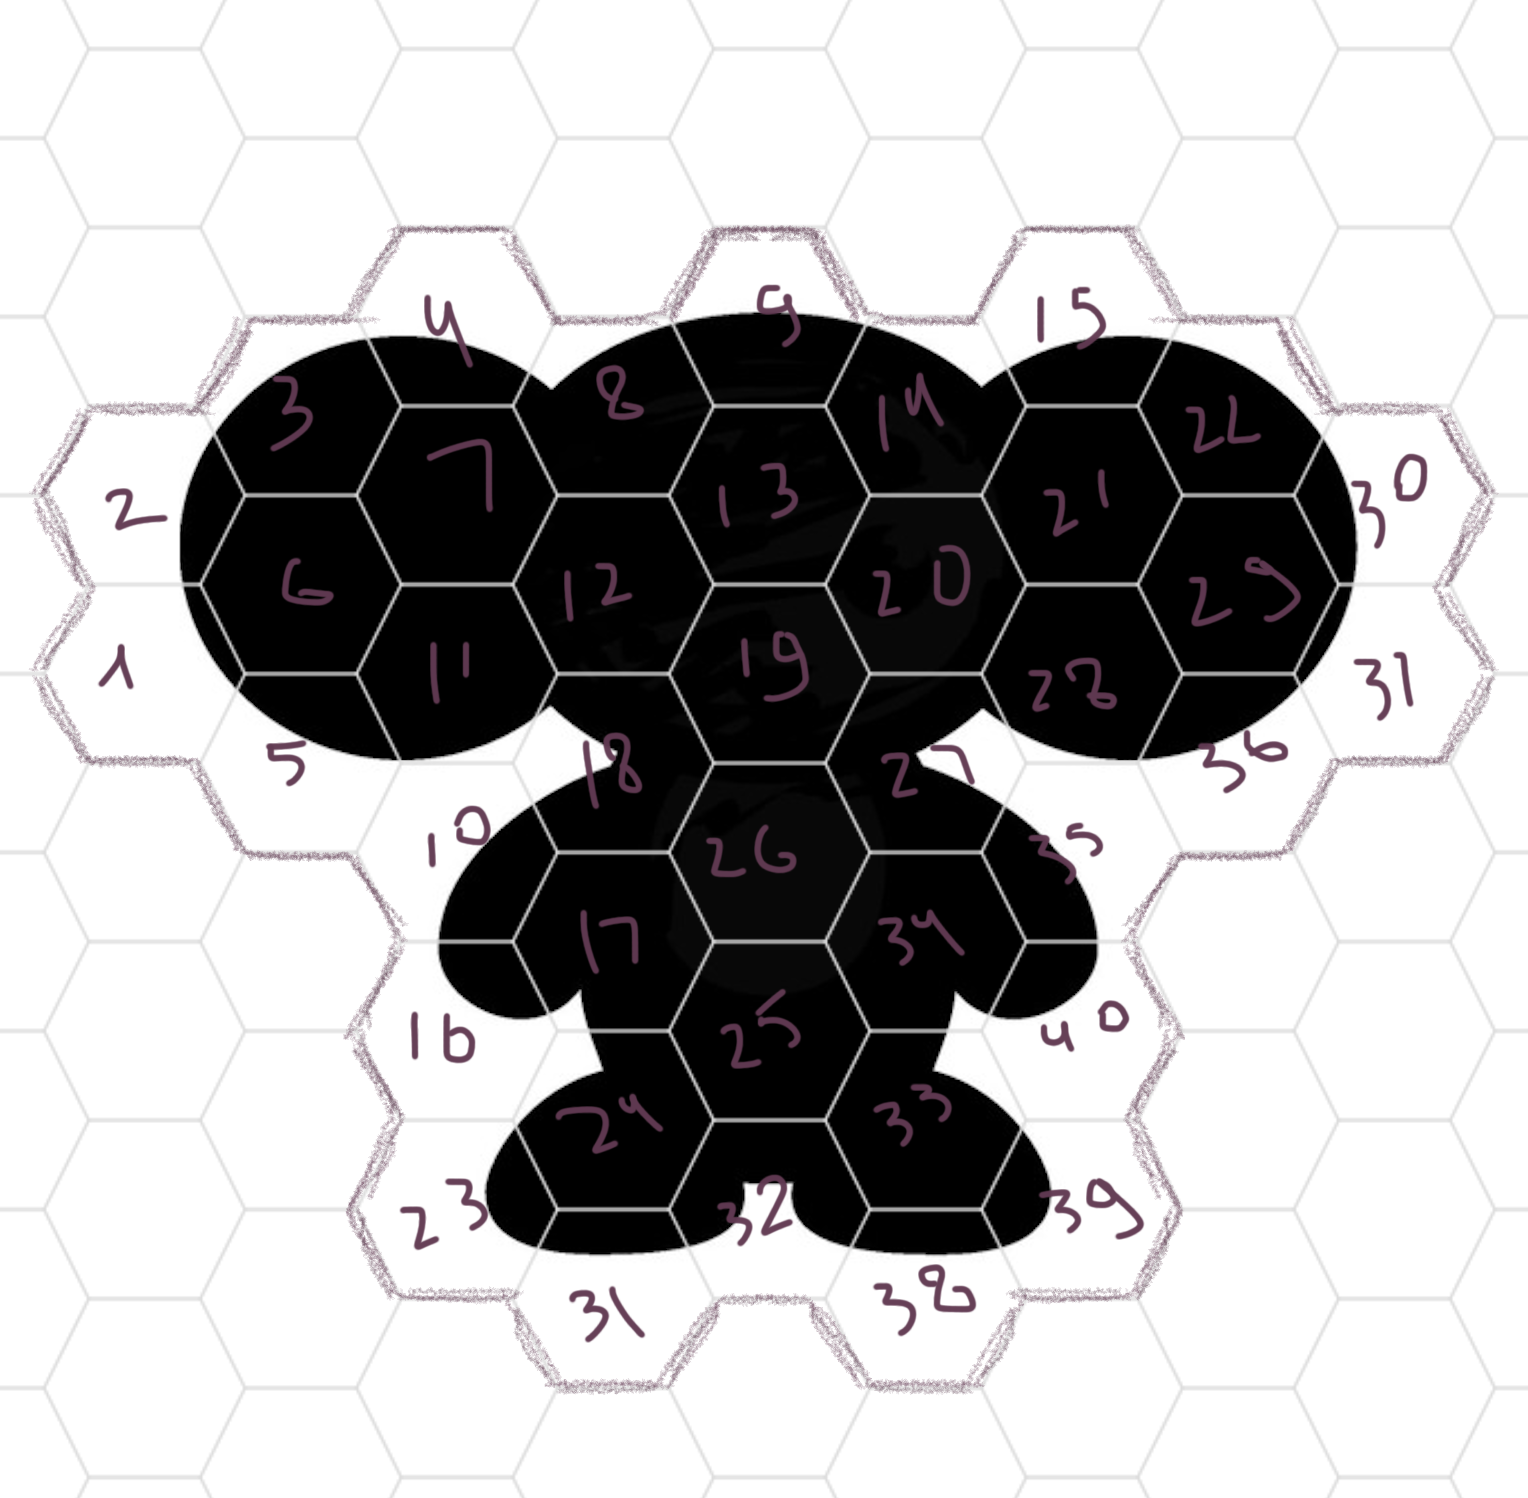

In [ ]:
import cv2
import math
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw
import random
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [ ]:
mpl.style.use(['ggplot'])

### **Расчет матрицы смежности для сопредельных клеток**

Пары сопредельных шестиугольников такие, что $i < j$.

In [ ]:
adjacency_list = [(1, 2), (1, 5), (1, 6), (2, 3), (2, 6), (3, 4), (3, 6), (3, 7), (4, 7), (4, 8), (5, 6), (5, 10), (5, 11), (6, 7), (6, 11), (7, 8), (7, 11), (7, 12), (8, 9), (8, 12), (8, 13), (9, 13), (9, 14), (10, 16), (10, 17), (10, 18), (11, 12), (11, 18), (12, 13), (12, 19), (13, 14), (13, 19), (13, 20), (14, 15), (14, 20), (14, 21), (15, 21), (15, 22), (16, 17), (16, 23), (16, 24), (17, 18), (17, 24), (17, 25), (17, 26), (18, 19), (18, 26), (19, 20), (19, 26), (19, 27), (20, 21), (20, 27), (20, 28), (21, 22), (21, 28), (21, 29), (22, 29), (22, 30), (23, 24), (23, 31), (24, 25), (24, 31), (24, 32), (25, 26), (25, 32), (25, 33), (25, 34), (26, 27), (26, 34), (27, 28), (27, 34), (27, 35), (28, 29), (28, 35), (28, 36), (29, 30), (29, 36), (29, 37), (30, 37), (31, 32), (32, 33), (32, 38), (33, 34), (33, 38), (33, 39), (34, 35), (34, 40), (35, 36), (35, 40), (36, 37), (38, 39), (39, 40)]

In [ ]:
import numpy as np

def get_adj_matrix(connections, N):
    adj_matrix = np.zeros((N, N), dtype=int)

    for adj_i, adj_j in connections:
        adj_matrix[adj_i - 1, adj_j - 1] = 1
        adj_matrix[adj_j - 1, adj_i - 1] = 1

    np.fill_diagonal(adj_matrix, -np.sum(adj_matrix, axis=1))

    return adj_matrix

In [ ]:
matrix = get_adj_matrix(adjacency_list, 40)
matrix

array([[-3,  1,  0, ...,  0,  0,  0],
       [ 1, -3,  1, ...,  0,  0,  0],
       [ 0,  1, -4, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., -3,  1,  0],
       [ 0,  0,  0, ...,  1, -3,  1],
       [ 0,  0,  0, ...,  0,  1, -3]])

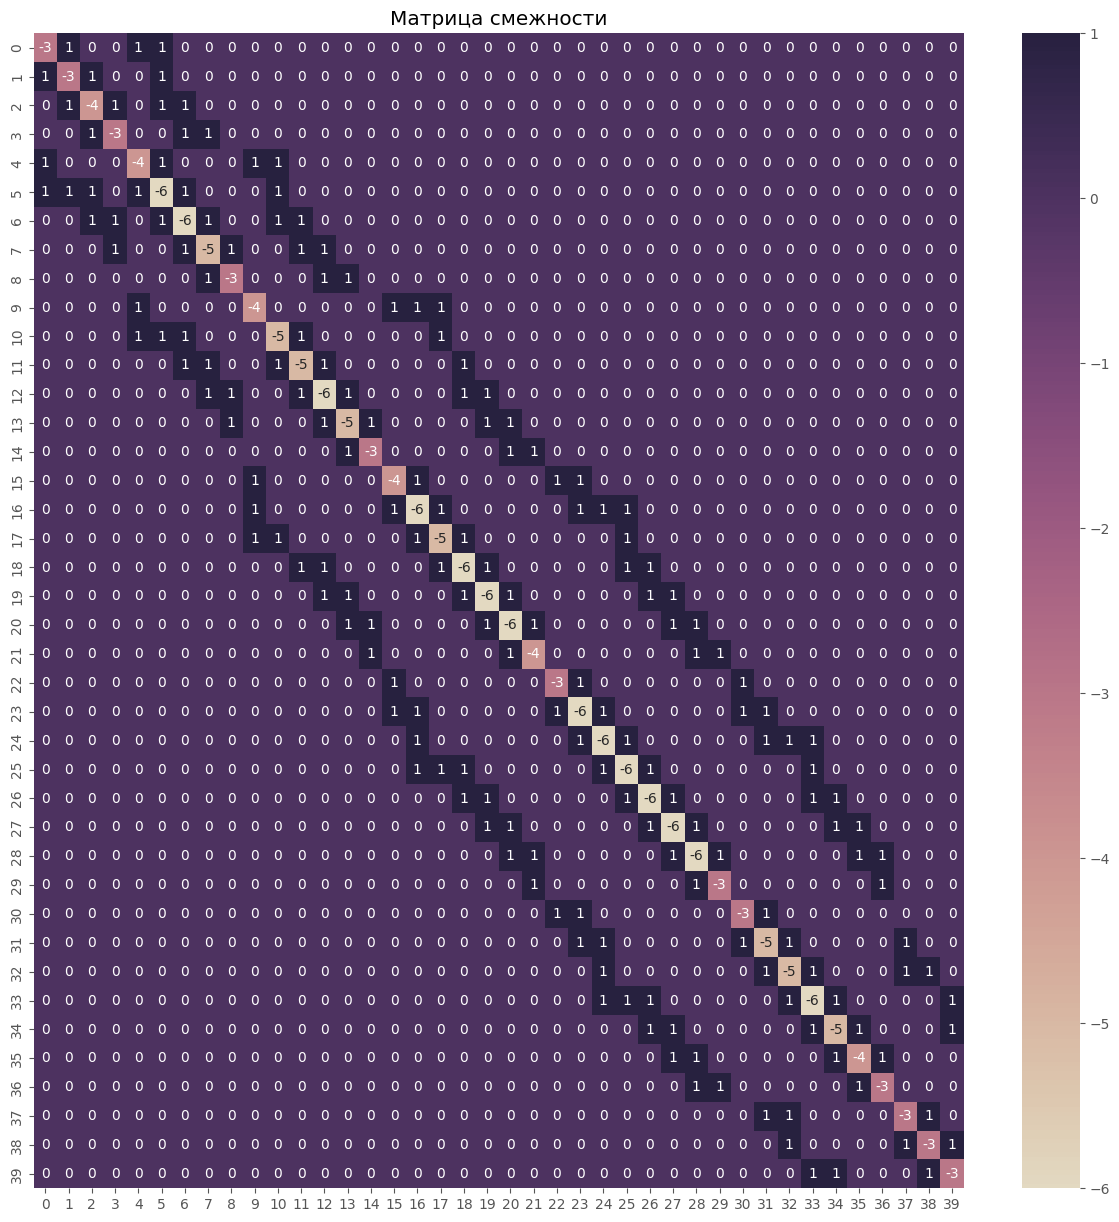

In [ ]:
plt.figure(figsize = (15, 15))
plt.title('Матрица смежности')
sns.heatmap(matrix, annot = True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

plt.show()

### **Реализация модели**

In [ ]:
import math

class Modeling:
    def __init__(self, x0, y0, tau, vx, vy, N_areas, adj_matrix, a_0, w, b=0.4, c=1.7):
        self.x = [x0.copy() for _ in range(N_areas)]
        self.y = [y0.copy() for _ in range(N_areas)]
        self.tau = tau
        self.t_arr = [[0, tau, tau * 2] for _ in range(N_areas)]
        self.vx_t = vx * tau
        self.vy_t = vy * tau
        self.adj_matrix = adj_matrix
        self.a_0 = a_0
        self.w = w
        self.b = b
        self.c = c

    def lotki_volterra(self, t, x, y):
        def a(t):
            return self.a_0 * (1 + math.sin(self.w * t))

        a_0 = -1 / 3
        a_1 = 1.5
        a_2 = -3
        a_3 = 11 / 6

        x_value = (self.tau * (a(t - self.tau) * x[-1] - x[-1] * y[-1]) - a_0 * x[-3] - a_1 * x[-2] - a_2 * x[-1]) / a_3
        y_value = (self.tau * (self.b * x[-1] * y[-1] - self.c * y[-1]) - a_0 * y[-3] - a_1 * y[-2] - a_2 * y[-1]) / a_3

        return [t, x_value, y_value]

    def compute_next(self):
        next_states = [
            self.lotki_volterra(self.t_arr[i][-1] + self.tau, self.x[i], self.y[i])
            for i in range(len(self.x))
        ]
        for i in range(len(self.x)):
            t_new, x, y = next_states[i]
            neighbours = [j for j in range(len(self.x)) if self.adj_matrix[i][j] > 0]
            x_i = x + self.vx_t * sum(next_states[j][1] - x for j in neighbours)
            y_i = y + self.vy_t * sum(next_states[j][2] - y for j in neighbours)
            self.x[i].append(x_i)
            self.y[i].append(y_i)
            self.t_arr[i].append(t_new)

    def compute(self, iters):
        for _ in range(iters):
            self.compute_next()

    def set_zeros(self, ind_list):
        for ind in ind_list:
            self.x[ind] = [0, 0, 0]
            self.y[ind] = [0, 0, 0]
            self.t_arr[ind] = self.t_arr[ind][:3]

    def at(self, ind):
        return self.t_arr[ind], self.x[ind], self.y[ind]


### **Начальные условия**

In [ ]:
x0 = [8.7, 9.2, 10]
y0 = [3.9, 4.2, 4.4]

In [ ]:
vx = 1 # количество мигрирущих жертв за ед. времени
vy = 1.3 # количество мигрирущих хищников за ед. времени

In [ ]:
grouped_models = Modeling(x0 = [9.5,9.7,10], y0 = [4, 4.3, 4.5], vx = 1, vy = 1.2,
                            N_areas=37, adj_matrix=matrix,
                            tau = 0.001,
                            a_0 = 5,
                            w = 0,
                            b = 0.4,
                            c = 1.7)
grouped_models.set_zeros([2, 6, 8, 12])
grouped_models.compute(iters = 10000)

### **Визуализация моделирования миграции**

In [ ]:
cells_to_visualize = [1, 5, 7, 11, 13, 26, 36]

In [ ]:
def visualize_cells(grouped_models, cells_to_visualize):
    num_cells = len(cells_to_visualize)
    fig, axes = plt.subplots(
        nrows=(num_cells + 2) // 3, ncols=3, figsize=(18, (num_cells + 2) // 3 * 5)
    )
    axes = axes.flatten()  # Преобразуем массив осей в одномерный для удобства
    fig.suptitle("Динамика численности популяций", fontsize=16)

    for idx, cell_i in enumerate(cells_to_visualize):
        ts, xs, ys = grouped_models.at(cell_i)
        ax = axes[idx]
        ax.grid(True, which='both')
        ax.minorticks_on()
        ax.plot(ts, xs, color='xkcd:sage', label="Жертвы (x)")
        ax.plot(ts, ys, color='#B7A0C5', label="Хищники (y)")
        ax.legend()
        ax.set_xlabel("Время, t")
        ax.set_ylabel("Численность")
        ax.set_title(f"Модель в ячейке {cell_i}")

    for idx in range(len(cells_to_visualize), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


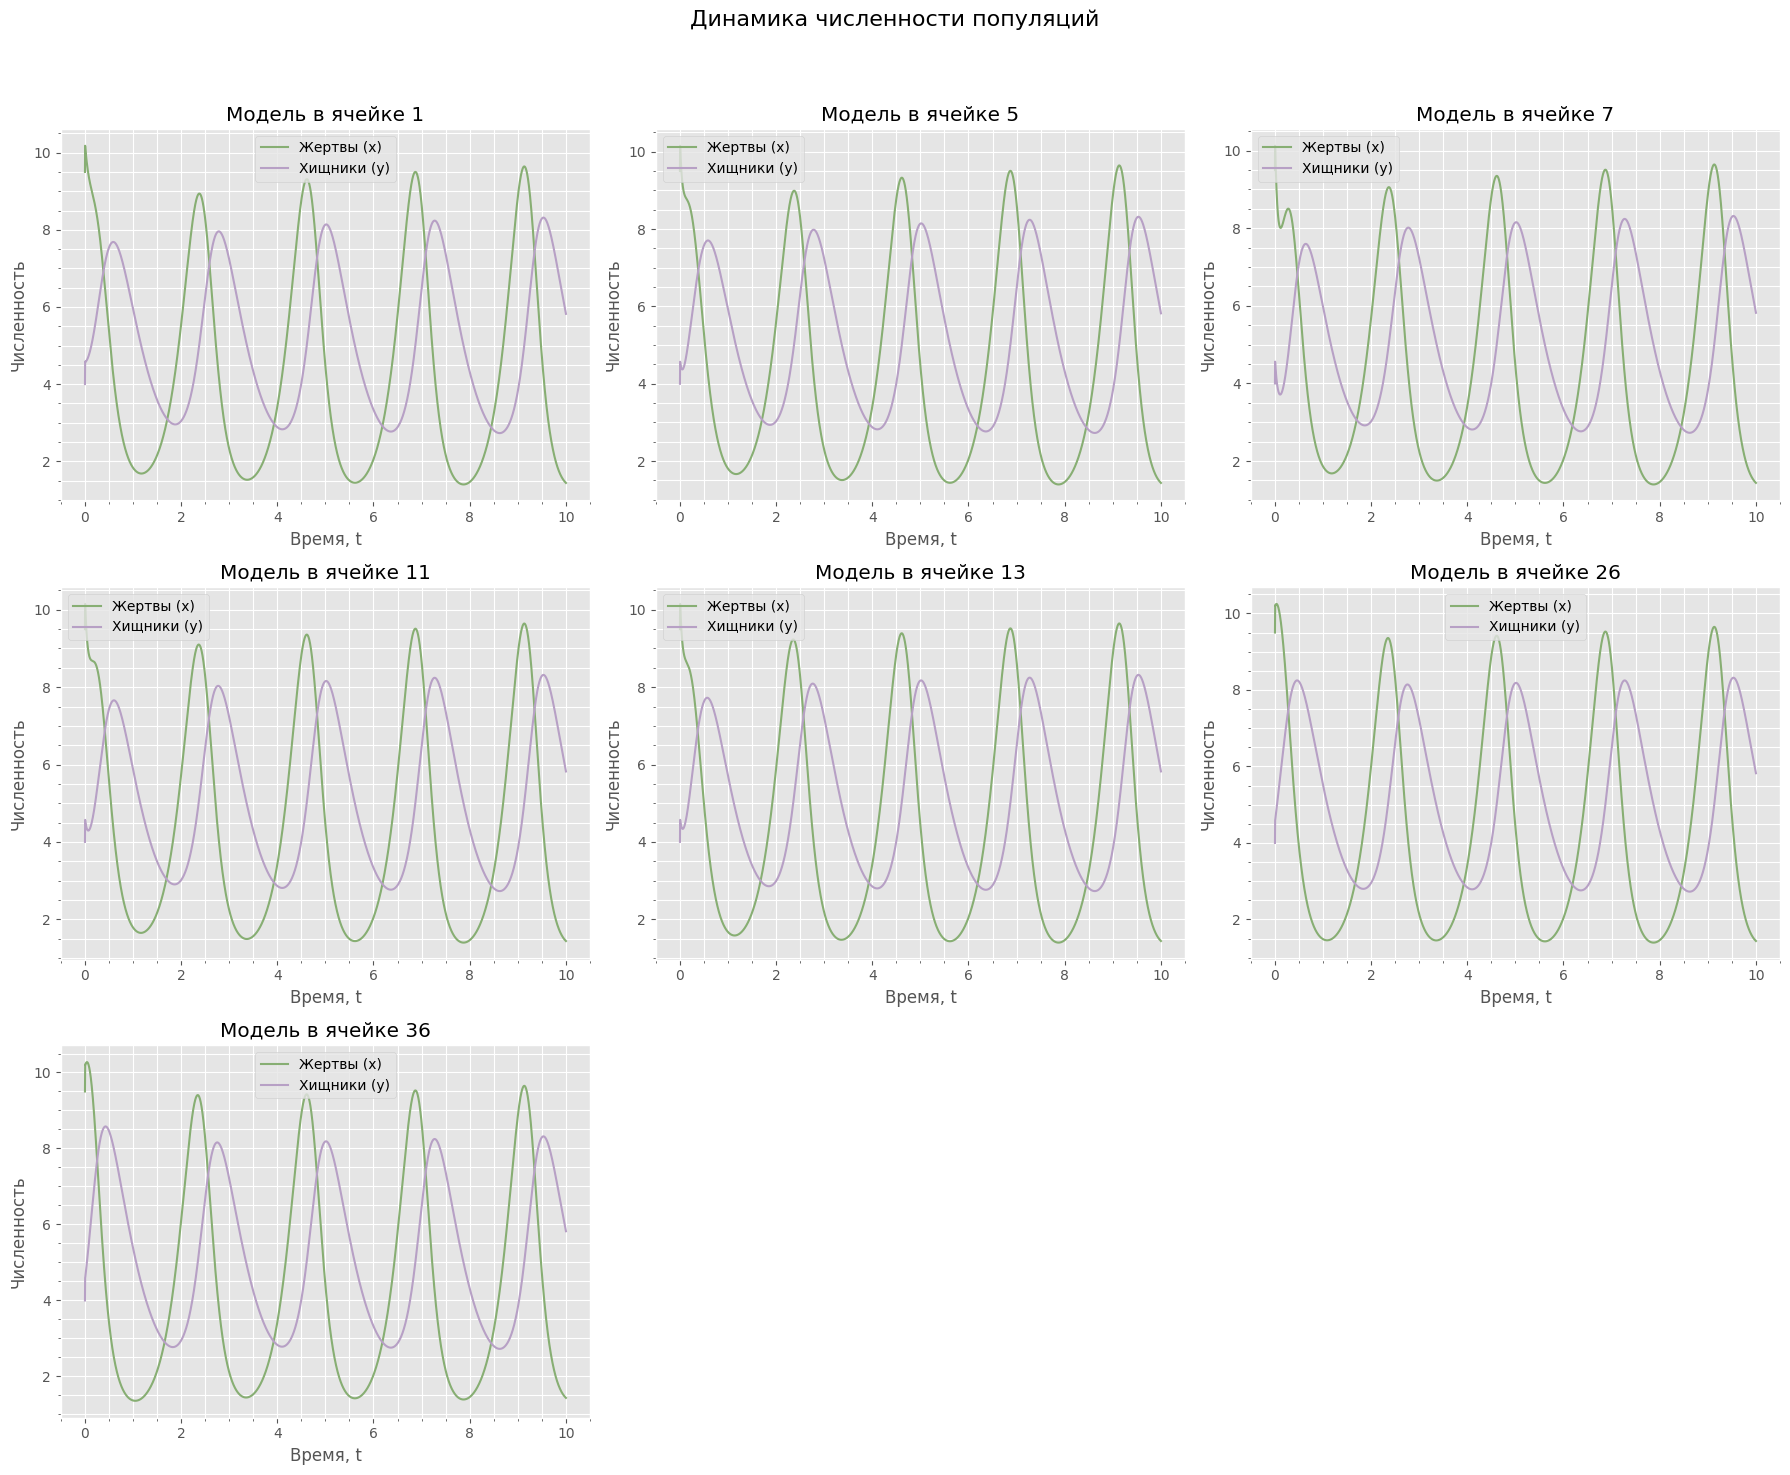

In [ ]:
visualize_cells(grouped_models, cells_to_visualize)

### **Оценка обусловленности моделирования миграции**

In [ ]:
def get_group_migration_matrix(adj_matrix, vi, tau_i):
    matrix = adj_matrix.copy().astype(float)
    matrix *= tau_i / 2 * vi

    for i in range(len(matrix)):
        matrix[i][i] += 1

    return matrix

In [ ]:
from numpy import linalg as LA
migr_matrix = get_group_migration_matrix(matrix, max(vx, vy), 0.001)
LA.cond(migr_matrix)

Число обусловленности близко к 1, следовательно, СЛАУ обусловлена довольно хорошо.

### **Практическое исследование обусловленности**

Уменьшим исходные значения для $x$ и $y$ на 0.3 и проверим, как малое изменение входных данных отразится на нашей сисетме:

In [ ]:
x0 = [value - 0.3 for value in x0]
y0 = [value - 0.3 for value in y0]

In [ ]:
migrated_grouped_models = Modeling(x0 = x0, y0 = y0, vx = 1, vy = 1.2,
                            N_areas=37, adj_matrix=matrix,
                            tau = 0.001,
                            a_0 = 5,
                            w = 0,
                            b = 0.4,
                            c = 1.7)
migrated_grouped_models.set_zeros([2, 6, 8, 12])
migrated_grouped_models.compute(iters=10000)

In [ ]:
def visualize_migrated_vs_original(grouped_models, migrated_grouped_models, cells_to_visualize):
    num_cells = len(cells_to_visualize)
    fig, axes = plt.subplots(
        nrows=(num_cells + 2) // 3, ncols=3, figsize=(18, (num_cells + 2) // 3 * 5)
    )
    axes = axes.flatten()  # Преобразуем массив осей в одномерный для удобства
    fig.suptitle("Сравнение динамики численности популяций", fontsize=16)

    for idx, cell_i in enumerate(cells_to_visualize):
        ts_m, xs_m, ys_m = migrated_grouped_models.at(cell_i)
        ts, xs, ys = grouped_models.at(cell_i)
        ax = axes[idx]
        ax.grid(True, which='both')
        ax.minorticks_on()

        ax.plot(ts, xs, color='#aa83a6', label="Жертвы (x)")
        ax.plot(ts, ys, color='xkcd:sage', label="Хищники (y)")
        ax.plot(ts, xs_m, color='#dda9b2', ls='--', label="Жертвы мигрировавшие (x)")
        ax.plot(ts, ys_m, color='#b4d3b2', ls='--', label="Хищники мигрировавшие (y)")

        ax.legend()
        ax.set_xlabel("Время, t")
        ax.set_ylabel("Численность")
        ax.set_title(f"Модель в ячейке {cell_i}")

    for idx in range(len(cells_to_visualize), len(axes)):
        fig.delaxes(axes[idx])  # Удаление лишних пустых осей

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


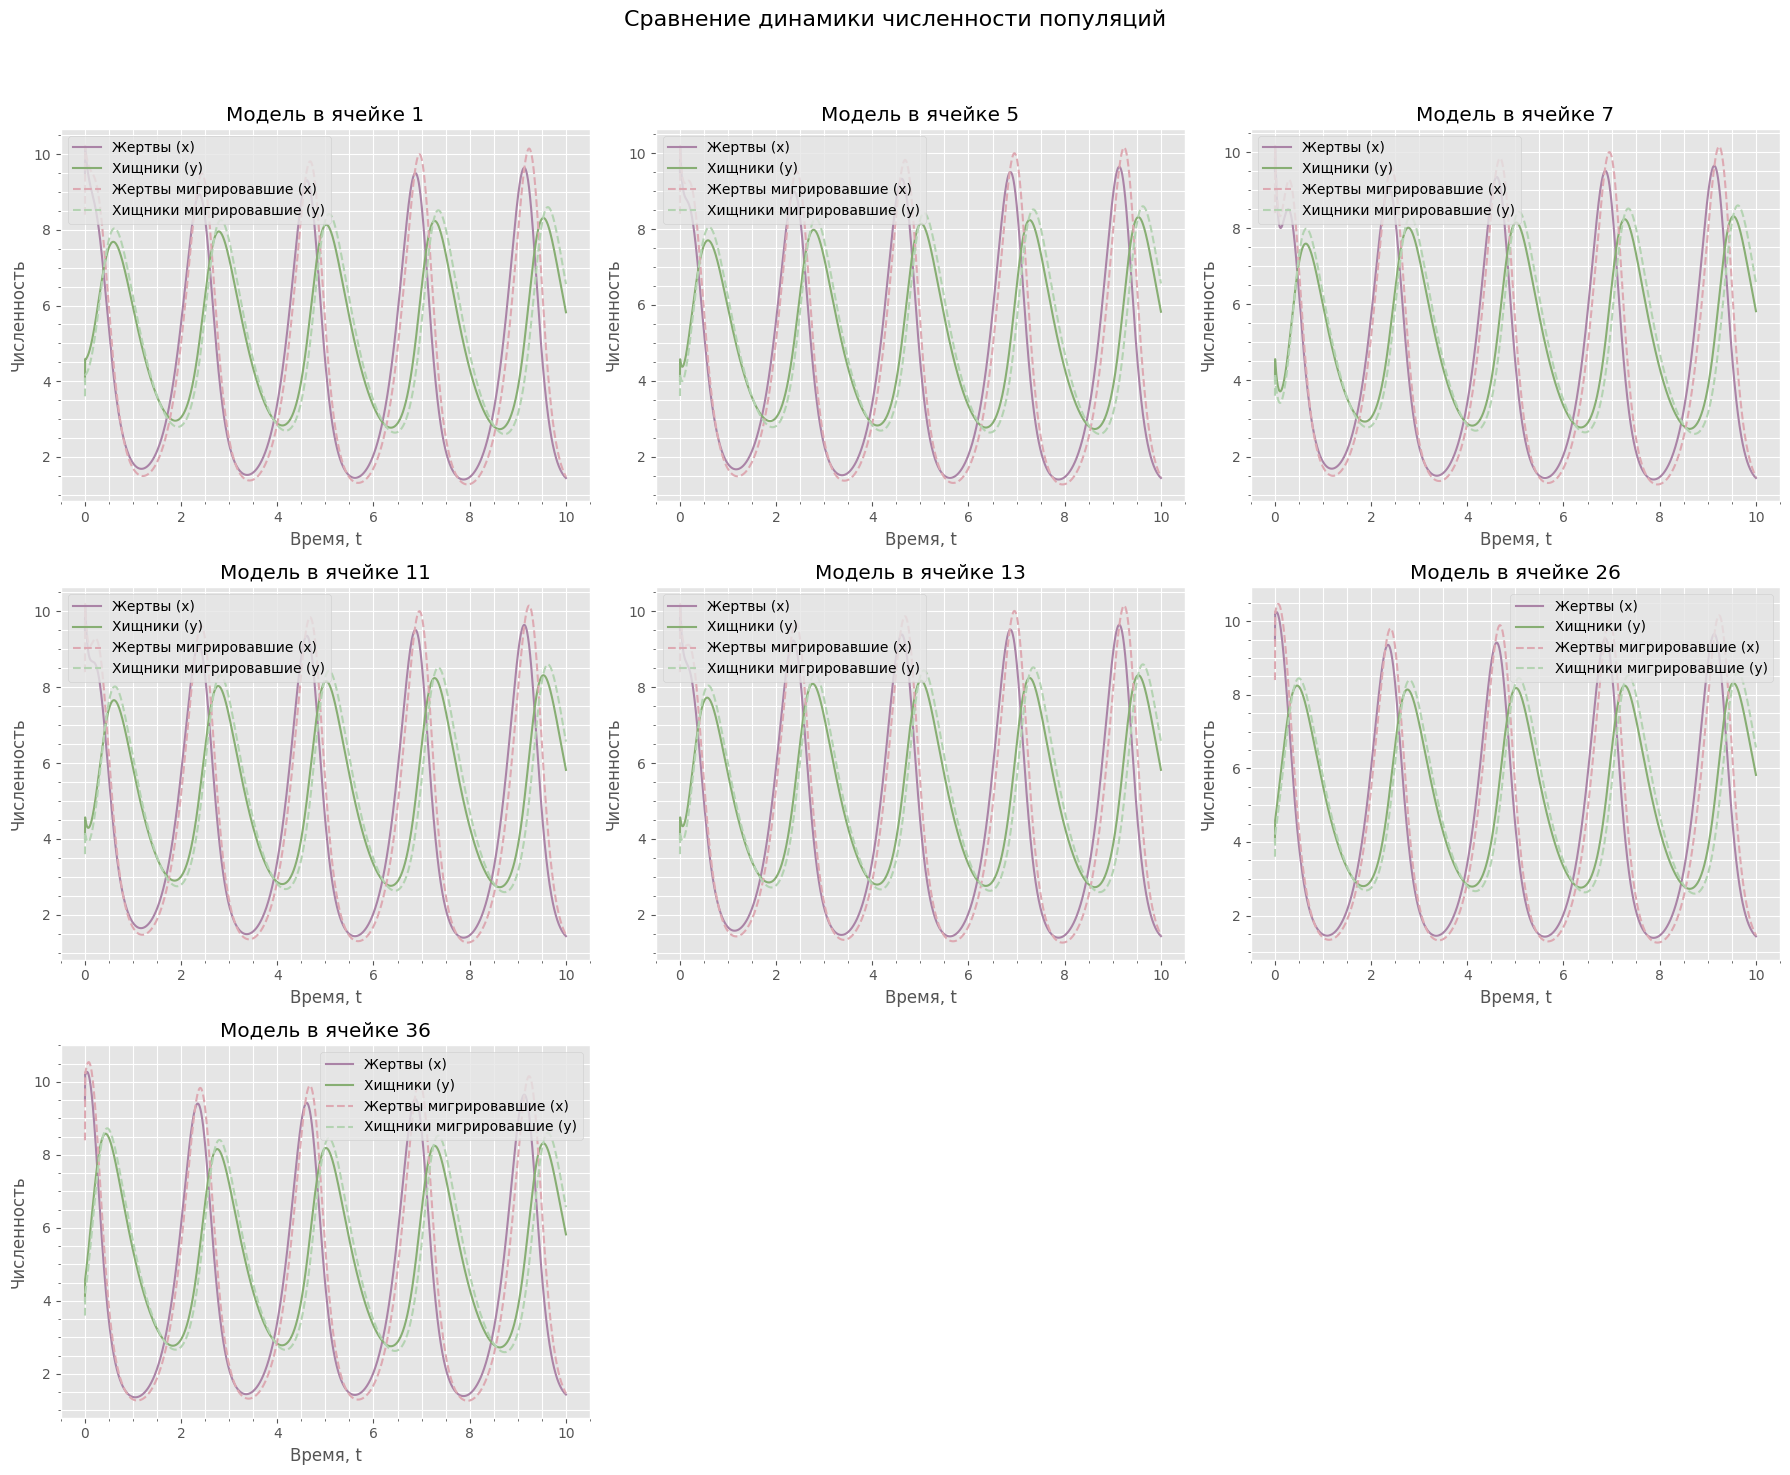

In [ ]:
visualize_migrated_vs_original(grouped_models, migrated_grouped_models, cells_to_visualize)

Данный эксперимент наглядно демонстрирует, что, при малых возмущениях входных данных, значения выходных данных также меняются незначительно. Можно сделать вывод о том, что СЛАУ обсуловлена хорошо (погрешность входных данных не сильно влияет на решение)